# Introduccion

hay distintas aperturas en las que se puede utilizar aperture_photometry() en photometria las cuales son:

- CircularAperture
- CircularAnnulus
- ElipticalAperture
- ElipticalAnnulus
- RectangularAperture
- RectangularAnnulus

Las cuales dependen de sus respectivas cordenadas Sky

## crear objetos de apertura

In [1]:
from photutils.aperture import CircularAperture
positions = [(30., 30.), (40., 40.)]
aperture = CircularAperture(positions, r=3.)

Primero se usa la funcion SkyCoord para definir las cordenadas en el cielo, y luego la funcion SkyCircularAperture para definir el objeto

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from photutils.aperture import SkyCircularAperture
positions = SkyCoord(l=[1.2, 2.3] * u.deg, b=[0.1, 0.2] * u.deg,
                     frame='galactic')
aperture = SkyCircularAperture(positions, r=4. * u.arcsec)

## convertir entre apretura y cielo

In [4]:
#WCS para mapear el pixel a la coordenada en la esfera celeste.
from astropy.wcs import WCS

In [9]:
import astropy.units as u
from astropy.wcs import WCS
from photutils.datasets import load_spitzer_image, load_spitzer_catalog
hdu = load_spitzer_image()  
data = u.Quantity(hdu.data, unit=hdu.header['BUNIT'])  
wcs = WCS(hdu.header)  
catalog = load_spitzer_catalog()  

pasar a cordenadas de cielo

In [16]:
aperture = CircularAperture((10, 20), r=4.)
sky_aperture = aperture.to_sky(wcs)
sky_aperture

<SkyCircularAperture(<SkyCoord (Galactic): (l, b) in deg
    (18.3835, 0.1365)>, r=4.799999952000944 arcsec)>


Pasar a cordenadas de pixeles

In [12]:
position = SkyCoord(1.2, 0.1, unit='deg', frame='icrs')
aperture = SkyCircularAperture(position, r=4. * u.arcsec)
pix_aperture = aperture.to_pixel(wcs)

In [13]:
pix_aperture

<CircularAperture([-240812.72259705, -182054.11204346], r=3.9722238220030643)>

## Realizar la Photometria de apertura

In [17]:
positions = [(30., 30.), (40., 40.)]
aperture = CircularAperture(positions, r=3.)

In [18]:
import numpy as np
from photutils.aperture import aperture_photometry
data = np.ones((100, 100))
phot_table = aperture_photometry(data, aperture)
phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
print(phot_table)


 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1    30.0    30.0    28.274334
  2    40.0    40.0    28.274334


area circulo de apertura

In [19]:
print(np.pi * 3. ** 2)  

28.274333882308138


## Apertura y superposicion de pixeles

In [23]:
phot_table = aperture_photometry(data, aperture, method='subpixel',
                                 subpixels=5)
print(phot_table)  


 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1    30.0    30.0        27.96
  2    40.0    40.0        27.96


## Múltiples aperturas en cada posición

In [24]:
radii = [3., 4., 5.]
apertures = [CircularAperture(positions, r=r) for r in radii]
phot_table = aperture_photometry(data, apertures)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)



 id xcenter ycenter aperture_sum_0 aperture_sum_1 aperture_sum_2
      pix     pix                                               
--- ------- ------- -------------- -------------- --------------
  1      30      30      28.274334      50.265482      78.539816
  2      40      40      28.274334      50.265482      78.539816


Aperturas elipticas

In [25]:
from photutils.aperture import EllipticalAperture
a = 5.
b = 3.
theta = np.pi / 4.
apertures = EllipticalAperture(positions, a, b, theta)
phot_table = aperture_photometry(data, apertures)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1      30      30     47.12389
  2      40      40     47.12389


In [26]:
a = [5., 6., 7.]
b = [3., 4., 5.]
theta = np.pi / 4.
apertures = [EllipticalAperture(positions, a=ai, b=bi, theta=theta)
             for (ai, bi) in zip(a, b)]
phot_table = aperture_photometry(data, apertures)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)


 id xcenter ycenter aperture_sum_0 aperture_sum_1 aperture_sum_2
      pix     pix                                               
--- ------- ------- -------------- -------------- --------------
  1      30      30       47.12389      75.398224      109.95574
  2      40      40       47.12389      75.398224      109.95574


## Resta de fondo

In [ ]:
phot_table = aperture_photometry(data - bkg, aperture)  

In [32]:
from photutils.aperture import CircularAnnulus
aperture = CircularAperture(positions, r=3)
annulus_aperture = CircularAnnulus(positions, r_in=6., r_out=8.)

In [33]:
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(data, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)


 id xcenter ycenter aperture_sum_0 aperture_sum_1
      pix     pix                                
--- ------- ------- -------------- --------------
  1      30      30      28.274334      87.964594
  2      40      40      28.274334      87.964594


In [34]:
 bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area

In [35]:
bkg_sum = bkg_mean * aperture.area
final_sum = phot_table['aperture_sum_0'] - bkg_sum
phot_table['residual_aperture_sum'] = final_sum
phot_table['residual_aperture_sum'].info.format = '%.8g'  # for consistent table output
print(phot_table['residual_aperture_sum'])  

residual_aperture_sum
---------------------
       -1.0658141e-14
       -1.0658141e-14


## Mediana recortada en sigma dentro de un anillo circular

In [37]:
from photutils.datasets import make_100gaussians_image
from photutils.aperture import CircularAperture, CircularAnnulus
data = make_100gaussians_image()
positions = [(145.1, 168.3), (84.5, 224.1), (48.3, 200.3)]
aperture = CircularAperture(positions, r=5)
annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)

In [38]:
annulus_masks = annulus_aperture.to_mask(method='center')

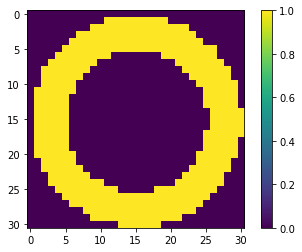

In [39]:
import matplotlib.pyplot as plt
plt.imshow(annulus_masks[0], interpolation='nearest')
plt.colorbar()

In [40]:
annulus_data = annulus_masks[0].multiply(data)

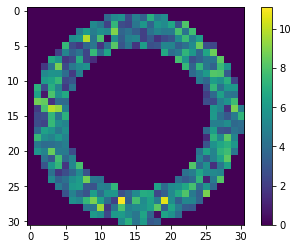

In [41]:
plt.imshow(annulus_data, interpolation='nearest')
plt.colorbar()

In [42]:
mask = annulus_masks[0].data
annulus_data_1d = annulus_data[mask > 0]
annulus_data_1d.shape


(394,)

In [43]:
from astropy.stats import sigma_clipped_stats
_, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
print(median_sigclip)  


4.848212997882959


In [44]:
background = median_sigclip * aperture.area
print(background)  

380.7777584296913


In [45]:
from astropy.stats import sigma_clipped_stats
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.datasets import make_100gaussians_image

data = make_100gaussians_image()
positions = [(145.1, 168.3), (84.5, 224.1), (48.3, 200.3)]
aperture = CircularAperture(positions, r=5)
annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)
annulus_masks = annulus_aperture.to_mask(method='center')

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)
phot = aperture_photometry(data, aperture)
phot['annulus_median'] = bkg_median
phot['aper_bkg'] = bkg_median * aperture.area
phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']
for col in phot.colnames:
    phot[col].info.format = '%.8g'  # for consistent table output
print(phot)

 id xcenter ycenter aperture_sum annulus_median  aper_bkg aper_sum_bkgsub
      pix     pix                                                        
--- ------- ------- ------------ -------------- --------- ---------------
  1   145.1   168.3    1131.5794       4.848213 380.77776       750.80166
  2    84.5   224.1    746.16064      5.0884354 399.64478       346.51586
  3    48.3   200.3    1250.2186      4.8060599 377.46706        872.7515


## Estimación de errores

Si y solo si la errorpalabra clave se ingresa en aperture_photometry(), la tabla devuelta incluirá una 'aperture_sum_err'columna además de 'aperture_sum'. 'aperture_sum_err'proporciona la incertidumbre propagada asociada con 'aperture_sum'.

Por ejemplo, supongamos que hemos calculado previamente el error en el valor de cada píxel y lo hemos guardado en la matriz error:

In [46]:
positions = [(30., 30.), (40., 40.)]
aperture = CircularAperture(positions, r=3.)
data = np.ones((100, 100))
error = 0.1 * data

phot_table = aperture_photometry(data, aperture, error=error)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)


 id xcenter ycenter aperture_sum aperture_sum_err
      pix     pix                                
--- ------- ------- ------------ ----------------
  1      30      30    28.274334       0.53173616
  2      40      40    28.274334       0.53173616


En el ejemplo anterior, se supone que la errorpalabra clave especifica el error total : incluye ruido de Poisson debido a fuentes individuales o dicho ruido es irrelevante. Sin embargo, a menudo se ha calculado una matriz uniforme de "error solo de fondo", que por diseño no incluye un aumento del ruido en los píxeles brillantes. Para incluir el ruido de Poisson de las fuentes, podemos usar la calc_total_error()función.

Supongamos que tenemos una imagen de solo fondo llamada bkg_error. Si nuestros datos están en unidades de electrones/s, usaríamos el tiempo de exposición como ganancia efectiva:

In [ ]:
from photutils.utils import calc_total_error
effective_gain = 500  # seconds
error = calc_total_error(data, bkg_error, effective_gain)  
phot_table = aperture_photometry(data - bkg, aperture, error=error)

## Enmascaramiento de píxeles

In [48]:
data = np.ones((5, 5))
aperture = CircularAperture((2, 2), 2.)
mask = np.zeros(data.shape, dtype=bool)
data[2, 2] = 100.  # bad pixel
mask[2, 2] = True
t1 = aperture_photometry(data, aperture, mask=mask)
t1['aperture_sum'].info.format = '%.8g'  # for consistent table output
print(t1['aperture_sum'])


aperture_sum
------------
   11.566371


In [49]:
t2 = aperture_photometry(data, aperture)
t2['aperture_sum'].info.format = '%.8g'  # for consistent table output
print(t2['aperture_sum'])

aperture_sum
------------
   111.56637


## Fotometría de apertura usando coordenadas del cielo

In [50]:
import astropy.units as u
from astropy.wcs import WCS
from photutils.datasets import load_spitzer_image, load_spitzer_catalog
hdu = load_spitzer_image()  
data = u.Quantity(hdu.data, unit=hdu.header['BUNIT'])  
wcs = WCS(hdu.header)  
catalog = load_spitzer_catalog()  

In [51]:
positions = SkyCoord(catalog['l'], catalog['b'], frame='galactic')  
aperture = SkyCircularAperture(positions, r=4.8 * u.arcsec)  

In [52]:
phot_table = aperture_photometry(data, aperture, wcs=wcs)  

In [53]:
import astropy.units as u
factor = (1.2 * u.arcsec) ** 2 / u.pixel
fluxes_catalog = catalog['f4_5']  
converted_aperture_sum = (phot_table['aperture_sum'] *
                          factor).to(u.mJy / u.pixel)  

Text(0, 0.5, 'Aperture photometry fluxes')

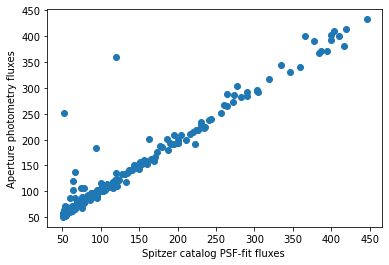

In [54]:
import matplotlib.pyplot as plt
plt.scatter(fluxes_catalog, converted_aperture_sum.value)
plt.xlabel('Spitzer catalog PSF-fit fluxes ')
plt.ylabel('Aperture photometry fluxes')

## Máscaras de apertura 

In [55]:
from photutils.aperture import CircularAperture
positions = [(30., 30.), (40., 40.)]
aperture = CircularAperture(positions, r=3.)

In [56]:
masks = aperture.to_mask(method='center')

In [57]:
mask = masks[0]
image = mask.to_image(shape=((200, 200)))

In [58]:
data_cutout = mask.cutout(data)

In [59]:
data_cutout_aper = mask.multiply(data)

## Definición de sus propias aperturas personalizadas

La aperture_photometry()función puede realizar fotometría de apertura en aperturas arbitrarias. Esta función acepta cualquier Apertureobjeto derivado, como CircularAperture. Esto simplifica la ampliación de la funcionalidad: un nuevo tipo de fotometría de apertura simplemente requiere la definición de una nueva Aperture subclase.

Todas las PixelAperturesubclases deben definir una bounding_boxespropiedad to_mask()y plot()métodos. También pueden definir opcionalmente una areapropiedad. Todas las SkyAperturesubclases solo deben implementar un to_pixel()método.

bounding_boxes: El cuadro delimitador mínimo para la apertura. Si la apertura es escalar, BoundingBoxse devuelve un solo. BoundingBoxDe lo contrario, se devuelve una lista de .

area: una propiedad opcional que define el área analítica exacta (en píxeles**2) de la apertura.

to_mask(): Devuelve una máscara para la apertura. Si la apertura es escalar, ApertureMaskse devuelve un solo. ApertureMaskDe lo contrario, se devuelve una lista de .

plot(): Un método para trazar la apertura en una matplotlib.axes.Axesinstancia.